# Modeling

Here, we are going to train different algorithms that are going to be able to predict the fair price for a future host.

In [ ]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 1. Import pipeline from backend
sys.path.append('../backend')
from preprocessing import clean_airbnb_data, prepare_for_modeling

# 2. Charge raw data
print("Charging data...")
df_raw = pd.read_csv('../data/listings.csv')

# 3. Phase 1: Cleaning and Feature Engineering (Haversine, Amenities, etc.)
print("Applying cleaning and feature engineering...")
df_clean = clean_airbnb_data(df_raw)

# 4. Phase 2: Preparation for ML (One-Hot Encoding, text, etc.)
print("Transforming variables for modeling...")
df_ml = prepare_for_modeling(df_clean)

p99 = df_ml['price'].quantile(0.99)
print(f"🚨 99th Percentile threshold calculated at: {round(p99, 2)} $") # <- We do this because we want to give service 
                                                                        # to 99% of people, not to that 1% luxury apartments

df_filtered = df_ml[df_ml['price'] <= p99].copy()

# 5. Separate X and y
X = df_filtered.drop(columns=['price'])
y = df_filtered['price']

# 6. Stratified Split based on quantiles of price
print("Stratified Train-Test Split...")
bins_price = pd.qcut(y, q=20, labels=False, duplicates='drop')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=bins_price
)
# 7. Quality control
print("\n✅ ¡Data ready for modeling!")
print(f"🎯 Shape of X_train: {X_train.shape}")
print(f"🔒 Shape of X_test: {X_test.shape}")
print("-" * 30)
print(f"💶 Mean of price in Train: {round(y_train.mean(), 2)} €")
print(f"💶 Mean of price in Test:  {round(y_test.mean(), 2)} €")

Charging data...
Applying cleaning and feature engineering...
Transforming variables for modeling...
🚨 99th Percentile threshold calculated at: 797.0 $
Stratified Train-Test Split...

✅ ¡Data ready for modeling!
🎯 Shape of X_train: (14937, 71)
🔒 Shape of X_test: (3735, 71)
------------------------------
💶 Mean of price in Train: 131.58 €
💶 Mean of price in Test:  131.61 €


In [10]:
df_ml.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,...,neighbourhood_group_cleansed_Usera,neighbourhood_group_cleansed_Vicálvaro,neighbourhood_group_cleansed_Villa de Vallecas,neighbourhood_group_cleansed_Villaverde,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathrooms_per_person,accommodates_per_bed,occupancy_rate_30d
listing_url,,,,,,,,,,,,,,,,,,,,,
https://www.airbnb.com/rooms/30320,4,100.0,100.0,0,1,1,40.41476,-3.70418,2,1.0,...,0,0,0,0,0,0,0,0.500,1.000000,0.466667
https://www.airbnb.com/rooms/40916,4,100.0,100.0,0,1,1,40.42247,-3.70577,2,1.0,...,0,0,0,0,0,0,0,0.500,0.666667,0.666667
https://www.airbnb.com/rooms/62423,4,100.0,99.0,0,1,1,40.41884,-3.69655,4,1.0,...,0,0,0,0,0,1,0,0.375,2.000000,0.866667
https://www.airbnb.com/rooms/70073,4,100.0,100.0,0,1,1,40.42252,-3.70250,2,1.0,...,0,0,0,0,0,0,0,0.500,2.000000,0.900000
https://www.airbnb.com/rooms/70310,4,100.0,100.0,0,1,1,40.42252,-3.70250,2,1.0,...,0,0,0,0,0,0,0,0.500,1.000000,1.000000


## Modeling Technique Candidates

In this case, as we have seen non-linear relationships in the EDA and they are always a good choice we are going to try the following algorithms and see which is going to be our "brain" for the final app:

* **Linear Regression** (baseline)
* **Decision Tree** (easy to understand, but tend to overfit)
* **Random Forest**: creates hundreds of independent decision trees and makes them vote (Bagging). Robust to outliers.
* **LightGMB and XGBoost**: are Boosting based models. They create sequential trees where each tree tries to correct the previous tree errors.
* **MLP (Multilayer Perceptron)**: Neural Network that 

### Evaluation Metric
These are the main metrics and why we are going to choose **MAE**:

1. **MAE (Mean Absolute Error)**
It treats all errors the same. If it fails by 10$ in a cheap apartment is the same as failing by 10$ in an expensive one. It is the perfect metric for this problem.

2. **RMSE (Root Mean Squared Error)**
It penalizes exponentially big errors. We have to remember that we have luxury flats of 3,000$/night. If the model predicts 1,000$ for that flat, the error is of 2,000$. The RMSE will square that error (4,000,000) and will try to adjust by making worse predicitons in the 80$ flats.

3. **MAPE (Mean Absolute Percentage Error)**
It is pretty good for business (My model is wrong by 15%, on average). But matematically, it is unstable if you have prices close to 0 (as you divide by the real price).

## Cold Evaluation

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 0. EVALUATION STRATEGY
# ==========================================
# We use K-Fold CV on X_train to keep X_test strictly unseen
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================
# 1. MODEL DEFINITION
# ==========================================
# Pipelines are used for models that require scaled data (Distance, Price, etc.)
models = {
    "Linear Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", LinearRegression())
    ]),
    
    "Decision Tree": DecisionTreeRegressor(
        random_state=42
    ),
    
    "Random Forest": RandomForestRegressor(
        n_estimators=100,
        random_state=42, 
        n_jobs=-1
    ),
    
    "LightGBM": LGBMRegressor(
        random_state=42, 
        n_jobs=-1, 
        verbose=-1
    ),
    
    "XGBoost": XGBRegressor(
        random_state=42, 
        n_jobs=-1
    ),
    
    "MLP (Neural Network)": Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
    ])
}

# ==========================================
# 2. "COLD" EVALUATION (CROSS-VALIDATION)
# ==========================================
results = []

print("🚀 Starting Cold Start Tuning (Cross-Validation)...\n")

for name, model in models.items():
    
    # We evaluate using 3 key Regression metrics
    cv_scores = cross_validate(
        model, 
        X_train, 
        y_train, 
        cv=kf, 
        scoring=('neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'),
        n_jobs=-1
    )
    
    # Extract mean scores (convert negative errors to positive)
    mae = -cv_scores['test_neg_mean_absolute_error'].mean()
    rmse = -cv_scores['test_neg_root_mean_squared_error'].mean()
    r2 = cv_scores['test_r2'].mean()
    
    # Save results
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2-Score": r2
    })
    
    print(f"✅ {name} evaluated. MAE: {mae:.2f}€ | R2: {r2:.3f}")

# ==========================================
# 3. RESULTS VISUALIZATION
# ==========================================
results_df = pd.DataFrame(results).set_index("Model")

# Sort by MAE (Lower is better)
results_df = results_df.sort_values(by="MAE", ascending=True)

print("\n🏆 RESULTS TABLE (Ordered by Lowest MAE):")
# We use reversed Greens for MAE/RMSE (lower is greener) and Blues for R2
styled_table = (
    results_df.style
    .background_gradient(cmap="Greens_r", subset=["MAE", "RMSE"])
    .background_gradient(cmap="Blues", subset=["R2-Score"])
    .format("{:.2f}")
)

display(styled_table)

🚀 Starting Cold Start Tuning (Cross-Validation)...



✅ Linear Regression evaluated. MAE: 42.89€ | R2: 0.504
✅ Decision Tree evaluated. MAE: 46.20€ | R2: 0.269
✅ Random Forest evaluated. MAE: 32.50€ | R2: 0.662
✅ LightGBM evaluated. MAE: 31.58€ | R2: 0.688
✅ XGBoost evaluated. MAE: 32.34€ | R2: 0.677
✅ MLP (Neural Network) evaluated. MAE: 43.52€ | R2: 0.497

🏆 RESULTS TABLE (Ordered by Lowest MAE):


,MAE,RMSE,R2-Score
Model,,,
LightGBM,31.58,54.23,0.69
XGBoost,32.34,55.14,0.68
Random Forest,32.50,56.46,0.66
Linear Regression,42.89,68.31,0.50
MLP (Neural Network),43.52,68.80,0.50
Decision Tree,46.20,82.90,0.27


As we can see, the tree models perform extremely well on this data, explaining nearly a 70% of the variance!

We are going to fine-tune these models in order to know which is going to be our final selection.

## Model Validation ("Fine-Tuning")

In this phase, we apply a **"Champion vs. Challengers"** strategy. We take the top-performing algorithms from the Cold Evaluation and subject them to rigorous Hyperparameter Tuning using `RandomizedSearchCV`.

**Key Architectural Decisions:**
1. **No Data Leakage:** We strictly perform tuning using **Cross-Validation (CV) on the Training Set only**. The Test Set remains completely isolated to prevent the models from indirectly "memorizing" the final exam.
2. **Continuous Search Spaces:** Instead of hardcoding static lists (Grid Search), we use statistical distributions (`scipy.stats.uniform` and `randint`) to allow the algorithms to explore thousands of highly optimized parameter combinations efficiently.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings

warnings.filterwarnings("ignore")

print("🔇 Silent Warnings. Starting Phase 2: Top 3 Tuning...\n")

# ==========================================
# 1. DEFINE TOP 3 MODELS & PARAMETER GRIDS
# ==========================================
# We use scipy.stats (randint, uniform) to let the algorithm sample 
# from a continuous range of values, which is much better than hardcoding lists.

tuning_grid = {
    "LightGBM": {
        "model": LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
        "params": {
            'n_estimators': randint(100, 800),
            'learning_rate': uniform(0.01, 0.15),
            'num_leaves': randint(20, 100),
            'max_depth': randint(-1, 20),
            'subsample': uniform(0.6, 0.4), # from 0.6 to 1.0
            'colsample_bytree': uniform(0.6, 0.4)
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42, n_jobs=-1),
        "params": {
            'n_estimators': randint(100, 800),
            'learning_rate': uniform(0.01, 0.15),
            'max_depth': randint(3, 12),
            'subsample': uniform(0.6, 0.4),
            'colsample_bytree': uniform(0.6, 0.4)
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            'n_estimators': randint(100, 500),
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': randint(2, 10),
            'min_samples_leaf': randint(1, 5)
        }
    }
}

# ==========================================
# 2. RUN RANDOMIZED SEARCH FOR EACH MODEL
# ==========================================
tuned_results = []
best_models = {}

for name, config in tuning_grid.items():
    print(f"⚙️ Tuning {name}...")
    
    search = RandomizedSearchCV(
        estimator=config["model"],
        param_distributions=config["params"],
        n_iter=20, # Tests 20 random combinations per model
        scoring='neg_mean_absolute_error',
        cv=5,      # 5-Fold Cross Validation
        verbose=1, # Set to 1 if you want to see the progress bar
        random_state=42,
        n_jobs=-1
    )
    
    # Train the searcher
    search.fit(X_train, y_train)
    
    # Save the best model object
    best_models[name] = search.best_estimator_
    
    # Save the metrics
    best_mae = -search.best_score_
    
    tuned_results.append({
        "Model": name,
        "Tuned MAE (€)": best_mae,
        "Best Params": str(search.best_params_)
    })
    
    print(f"✅ {name} best MAE: {best_mae:.2f} €\n")

# ==========================================
# 3. SHOW THE FINAL TUNED LEADERBOARD
# ==========================================
tuned_df = pd.DataFrame(tuned_results).set_index("Model")
tuned_df = tuned_df.sort_values(by="Tuned MAE (€)", ascending=True)

print("🏆 FINAL TUNED LEADERBOARD (Phase 2) 🏆")
display(
    tuned_df[["Tuned MAE ($)"]].style
    .background_gradient(cmap="Greens_r")
    .format("{:.2f}")
)

🔇 Silent Warnings. Starting Phase 2: Top 3 Tuning...

⚙️ Tuning LightGBM...
✅ LightGBM best MAE: 29.91 €

⚙️ Tuning XGBoost...
✅ XGBoost best MAE: 29.72 €

⚙️ Tuning Random Forest...
✅ Random Forest best MAE: 32.42 €

🏆 FINAL TUNED LEADERBOARD (Phase 2) 🏆


,Tuned MAE (€)
Model,
XGBoost,29.72
LightGBM,29.91
Random Forest,32.42


## Final Evaluation

In this final phase, we unseal the **Test Set (`X_test`)** for the first and only time. This acts as our "Real World Simulation" to ensure our models have generalized the market rules and are not simply overfitting the training data.

**The Ensemble Strategy (Stacking):**
Since our top candidates (LightGBM, XGBoost, and Random Forest) demonstrated very similar and highly competitive performance during validation, picking just one would mean leaving predictive power on the table. Instead, we combine them into a **Stacking Ensemble**. 

We use a Meta-Learner (Ridge Regression) that uses internal Cross-Validation to learn the optimal weights for each base model's predictions. This "Wisdom of the Crowds" approach allows us to capitalize on the unique strengths of each algorithm while smoothing out their individual blind spots.

**Business Metrics Evaluated:**
* **MAE (€):** Mean Absolute Error (Our core business metric - average error in euros per night).
* **MAPE (%):** Mean Absolute Percentage Error (Highly interpretable for stakeholders).
* **RMSE (€):** Root Mean Squared Error (Penalizes massive prediction errors, e.g., on luxury properties).
* **R2-Score:** The percentage of variance in price explained by our features.

🚀 PHASE 3: FINAL EVALUATION & STACKING ENSEMBLE...

Unsealing the X_test vault for the Top 3 Models...

🧠 Forging the Stacking Ensemble (Optimizing weights via Meta-Learner)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.2s remaining:   28.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished



🏆 FINAL TEST SET LEADERBOARD (Real World Simulation) 🏆


,Final MAE (€),Final RMSE (€),Final MAPE (%),Final R2
Model,,,,
🤖 STACKING ENSEMBLE (Optimized Weights),28.23,48.13,23.63,0.75
XGBoost,28.66,49.81,24.34,0.74
LightGBM,28.70,48.28,24.58,0.75
Random Forest,31.21,53.95,27.20,0.69


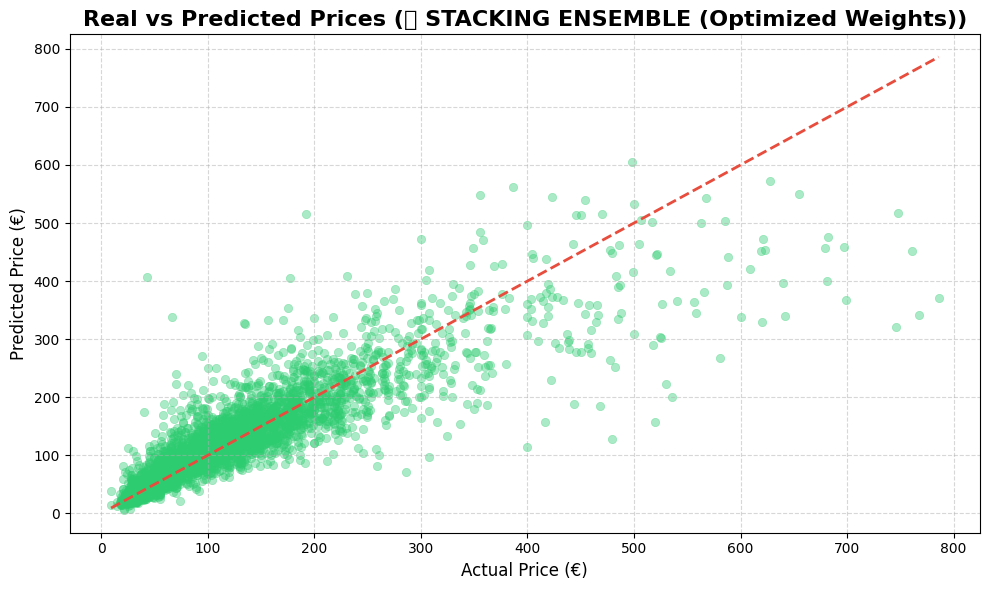

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

print("🚀 PHASE 3: FINAL EVALUATION & STACKING ENSEMBLE...\n")

final_results = []
predictions_dict = {}

# ==========================================
# 1. EVALUATE INDIVIDUAL TUNED MODELS
# ==========================================
print("Unsealing the X_test vault for the Top 3 Models...")

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    predictions_dict[name] = y_pred
    
    final_results.append({
        "Model": name,
        "Final MAE (€)": mean_absolute_error(y_test, y_pred),
        "Final RMSE (€)": np.sqrt(mean_squared_error(y_test, y_pred)),
        "Final MAPE (%)": mean_absolute_percentage_error(y_test, y_pred) * 100,
        "Final R2": r2_score(y_test, y_pred)
    })

# ==========================================
# 2. CREATE THE STACKING ENSEMBLE (Optimized Weights)
# ==========================================
print("\n🧠 Forging the Stacking Ensemble (Optimizing weights via Meta-Learner)...")
# Note: This might take 1-2 minutes as it uses internal Cross-Validation to find the perfect weights

estimators = [
    ('lgbm', best_models['LightGBM']),
    ('xgb', best_models['XGBoost']),
    ('rf', best_models['Random Forest'])
]

# The Meta-Learner (Ridge Regression) will figure out the optimal weights
stacking_ensemble = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(),
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Train the Stacking Ensemble on Train data
stacking_ensemble.fit(X_train, y_train)

# Predict on Test data
stacking_pred = stacking_ensemble.predict(X_test)
predictions_dict["🤖 STACKING ENSEMBLE (Optimized Weights)"] = stacking_pred

final_results.append({
    "Model": "🤖 STACKING ENSEMBLE (Optimized Weights)",
    "Final MAE (€)": mean_absolute_error(y_test, stacking_pred),
    "Final RMSE (€)": np.sqrt(mean_squared_error(y_test, stacking_pred)),
    "Final MAPE (%)": mean_absolute_percentage_error(y_test, stacking_pred) * 100,
    "Final R2": r2_score(y_test, stacking_pred)
})

# ==========================================
# 3. DISPLAY FINAL REAL-WORLD LEADERBOARD
# ==========================================
final_df = pd.DataFrame(final_results).set_index("Model")
final_df = final_df.sort_values(by="Final MAE (€)", ascending=True)

print("\n🏆 FINAL TEST SET LEADERBOARD (Real World Simulation) 🏆")
display(
    final_df.style
    .background_gradient(cmap="Greens_r", subset=["Final MAE (€)", "Final RMSE (€)", "Final MAPE (%)"])
    .background_gradient(cmap="Blues", subset=["Final R2"])
    .format("{:.2f}")
)

# ==========================================
# 4. VISUALIZATION: WINNER PERFORMANCE
# ==========================================
best_final_model = final_df.index[0]
best_pred = predictions_dict[best_final_model]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=best_pred, alpha=0.4, color='#2ecc71', edgecolor=None)

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='#e74c3c')

plt.title(f"Real vs Predicted Prices ({best_final_model})", fontsize=16, fontweight='bold')
plt.xlabel("Actual Price (€)", fontsize=12)
plt.ylabel("Predicted Price (€)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

As we can see our model fails more in the more expensive apartments, but we are going to leave it like that in order any user tries to put into the system these prices.

In [18]:
import joblib
import os

print("💾 SAVING THE CHAMPION MODEL FOR PRODUCTION...\n")

# 1. Define the path (saving it directly into the backend folder)
# Make sure the 'backend' folder exists!
output_dir = '../backend/models'
os.makedirs(output_dir, exist_ok=True)
model_path = os.path.join(output_dir, 'airbnb_pricing_model.joblib')

# 2. Extract the best model (The Stacking Ensemble)
# In Phase 3, we stored it as '🤖 STACKING ENSEMBLE (Optimized Weights)' 
# or '🤖 STACKING ENSEMBLE (Optimized)' depending on the exact string you used
champion_name = "🤖 STACKING ENSEMBLE (Optimized Weights)" 

# Fallback just in case the name varies slightly in your dictionary
if champion_name not in predictions_dict:
    champion_name = list(predictions_dict.keys())[-1] 

final_model = stacking_ensemble

# 3. Save it to disk
joblib.dump(final_model, model_path)

print(f"✅ SUCCESS! Model saved at: {model_path}")
print(f"📦 Model size: {round(os.path.getsize(model_path) / (1024 * 1024), 2)} MB")
print("\n🎉 NOTEBOOK 02_Modeling.ipynb OFFICIALLY COMPLETED! 🎉")

💾 SAVING THE CHAMPION MODEL FOR PRODUCTION...

✅ SUCCESS! Model saved at: ../backend/models/airbnb_pricing_model.joblib
📦 Model size: 383.17 MB

🎉 NOTEBOOK 02_Modeling.ipynb OFFICIALLY COMPLETED! 🎉


In [ ]:
columnas_modelo = X_train.columns.tolist()
joblib.dump(columnas_modelo, '../backend/models/model_columns.joblib')
print(f"✅ Saved {len(columnas_modelo)} columns for the backend!")

✅ Saved 71 columns for the backend!
